# Toy simulation of a 6x1 array of dipoles

In this notebook I recreate some of the results from Warnick 2021 (see https://doi.org/10.1109/TAP.2020.3027593 ) using `NEC2-RA`.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from nec2array import (ArrayModel, VoltageSource, FreqSteps, Wire,
                       ExecutionBlock, RadPatternSpec)

## Build array element antenna

Start by creating a line `l12` (`tuple` type of length 2) using two 3D points `p1,p2` (`tuple`s of length 3).
Also set variables for wavelength of 1 meter and wire radius.

In [2]:
lambda_ = 1
p1 = (0., 0., -lambda_/2/2)
p2 = (0., 0., +lambda_/2/2)
l12 = (p1, p2)
wire_radius = 1e-6*lambda_

Then we initiate an `ArrayModel()` object.
To this we add a group called `ant_Z` to represent the z-directed antenna element.
This group consists of only one part, which we call `w`, that is a `Wire()` object.
The wire is defined by using the previously defined line `l12`.
To the wire we also add a port midway along it by using the part's `add_port()` method and setting its position argument to 0.5 (goes from 0 to 1.0) relative to this line.
One can also name the model and add some comments.

In [3]:
model_name = 'Warnick_6x1'
warnick6 = ArrayModel(model_name)
warnick6.set_commentline(warnick6.name)
warnick6.set_commentline('Author: T. Carozzi')
warnick6.set_commentline('Date: 2024-03-20')
warnick6['ant_Z']['w'] = Wire(*l12, wire_radius)
warnick6['ant_Z']['w'].add_port(0.5, 'the_port')

Wire(point_src=(0.0, 0.0, -0.25), point_dst=(0.0, 0.0, 0.25), radius=1e-06, nr_seg=0, port=Port(fractional_position=0.5, name='the_port', source=None))

Now the model should be segmented by calling the model's `segmentalize()` method.
Then we set up some execution settings such as frequencies, radiation pattern points in the horizontal plane, and an excitation of one volt on the port.
These parameters are passed as initiation arguments to the `ExecutionBlock()` class.

In [4]:
nr_freqs = 1
frq_cntr = 3.0e8 / lambda_ /1e6
frq_cntr_step = FreqSteps('lin', nr_freqs, frq_cntr)
warnick6.segmentalize(201, frq_cntr)
_port_ex = ('the_port', VoltageSource(1.0))
nph = 100
rps = RadPatternSpec(thets=90., nph=nph, dph=360/nph, phis=0.)
eb_arr = ExecutionBlock(frq_cntr_step, _port_ex, rps)

## Set up array of 6 elements with two different spacings and reference antenna to nr. 2

After having created the element model, one can pass to placing identical elements at array positions by using the array model's `arrayify()` method.
Then the simulation can be run by calling its `excite_1by1()` method with the execution block as argument.

The results are the EEPs. The default termination is due to NEC2, that is, short-circuit (SC). Open-circuit EEPs can be computed using the EEP's `transform_to()` method.

In [5]:
nr_ants = 6
ref_ant = 2
frq_idx = 0
pats_OC = []
pats_SC = []
pows_act_OC = []
pows_act_SC = []
# The two spacings in units of lambda:
spacefacs =  [0.5, 0.2]
for spfac in spacefacs:
    d = spfac*lambda_
    arr_pos =[[antnr*d-(nr_ants-1)/2*d, 0., 0.] for antnr in range(nr_ants)]
    warnick6.arrayify(element=['ant_Z'], array_positions=arr_pos)
    eepSCdat = warnick6.excite_1by1(eb_arr)
    pow_act_SC = eepSCdat.get_pow_arr()[frq_idx, ref_ant, ref_ant]
    pows_act_SC.append(pow_act_SC)
    # Get OC from SC through transformation:
    eepOCdat = eepSCdat.transform_to('OC')
    pow_act_OC = (np.abs(eepOCdat.current_excite)**2
            *np.real(eepOCdat.impedances[frq_idx,ref_ant,ref_ant])/2.)
    pows_act_OC.append(pow_act_OC)
    _antspats = eepSCdat.get_antspats_arr()
    pats_SC.append(_antspats[:,0,0,:,:].squeeze())
    _antspats = eepOCdat.get_antspats_arr()
    pats_OC.append(_antspats[:,0,0,:,:].squeeze())

The array is simulated for two spacings by looping with two values in a list. This code block should run in just a few seconds on a modern laptop.

In [6]:
def dbi(efield, pow):
    eta = 377
    U = (np.abs(efield[:,0])**2 + np.abs(efield[:,1])**2)/(2*eta)
    dbi_ = 10*np.log10(U/pow*4*np.pi)
    return dbi_

## Plot the results

In [7]:
phis = rps.as_thetaphis()[1]

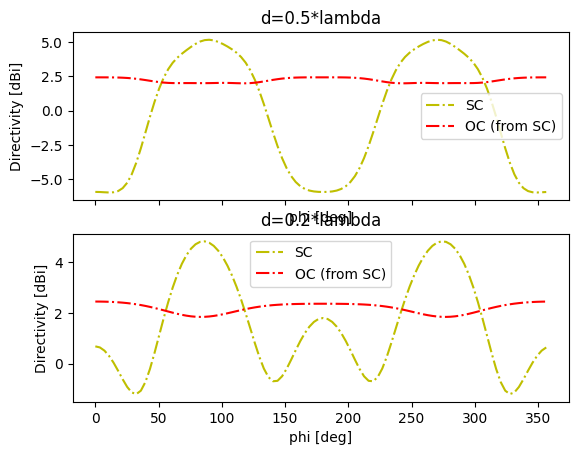

In [8]:
fig, axs = plt.subplots(2,1, sharex=True)
for spidx in range(len(spacefacs)):
    pat_SC_dbi = dbi(pats_SC[spidx][ref_ant,:], pows_act_SC[spidx])
    axs[spidx].plot(phis, pat_SC_dbi, 'y-.')
    pat_OC_dbi = dbi(pats_OC[spidx][ref_ant,:], pows_act_OC[spidx])
    axs[spidx].plot(phis, pat_OC_dbi, 'r-.')
    axs[spidx].set_title(f'd={spacefacs[spidx]}*lambda')
    axs[spidx].set_xlabel('phi [deg]')
    axs[spidx].set_ylabel('Directivity [dBi]')
    axs[spidx].legend(['SC', 'OC (from SC)'])
plt.show()

These are virtually identical to Figs 2 & 3 in Warnick2025. 